# Conditioned LSTM

In [1]:
import math
import random

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import gensim
from gensim.models import KeyedVectors
from gensim.models.lsimodel import LsiModel
from gensim.corpora.dictionary import Dictionary

D:\giuse\Conda\envs\thesis\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Data

In [2]:
with open('data/tokenized.txt','r') as f:
    tokenized = eval(f.read())

In [3]:
x_arr = np.load('data/x.npy')
y_arr = np.load('data/y.npy')

In [4]:
x_arr.shape

(17628, 133)

In [5]:
valid_split = 0.2

In [6]:
dataset_len = len(x_arr)
ids = list(range(dataset_len))

In [7]:
val_len = int(np.floor(valid_split * dataset_len))
val_ids = np.random.choice(ids, size=val_len, replace=False)

In [8]:
x_val = np.array(x_arr)[val_ids] 
y_val = np.array(y_arr)[val_ids]

In [9]:
x_val.shape, y_val.shape

((3525, 133), (3525, 133))

In [10]:
x_train = np.delete(x_arr, val_ids, axis=0)
y_train = np.delete(y_arr, val_ids, axis=0)

In [11]:
x_train.shape, y_train.shape

((14103, 133), (14103, 133))

In [12]:
def batches(x_arr, y_arr, batch_size):
    
    pos = 0
    
    for n in range(batch_size, x_arr.shape[0], batch_size):
        x = x_arr[pos:n]
        y = y_arr[pos:n]
        pos = n
        
        yield x, y

In [13]:
x_data = {'train': x_train , 'val': x_val}
y_data = {'train': y_train , 'val': y_val}

## Word Embeddings

In [14]:
w2v_model = gensim.models.KeyedVectors.load('w2v.model', mmap='r')

In [15]:
vocab_size, emdedding_size = w2v_model.wv.vectors.shape
vocab_size, emdedding_size

(33831, 128)

In [16]:
embedding_size = w2v_model.wv.vectors.shape[1]
embedding_size

128

In [17]:
w2v_tensors = torch.FloatTensor(w2v_model.wv.vectors)

## Topic Modelling

### Parameters

In [18]:
# model parameters used for LSA and PCA
n_hidden = 256
batch_size = 64
n_layers = 3

### Corpus

In [19]:
dct = Dictionary(tokenized)
dct.filter_extremes(no_below=5, no_above=0.1)

In [20]:
len(dct)

10435

In [21]:
print(dct)

Dictionary(10435 unique tokens: ['adaptation', 'address', 'albert', 'attention', 'auxiliary']...)


In [200]:
corpus = [dct.doc2bow(a) for a in tokenized]

tuple

### Latent Semantic Analysis (LSA)

In [23]:
lsi = LsiModel(corpus, id2word=dct, num_topics=n_hidden, decay=0.2)

In [24]:
lsi.show_topics(5)

[(0,
  '0.607*"de" + 0.316*"d" + 0.257*"la" + 0.253*"des" + 0.241*"les" + 0.205*"et" + 0.204*"l" + 0.144*"le" + 0.137*"r" + 0.135*"un"'),
 (1,
  '0.118*"attention" + 0.114*"question" + 0.104*"generation" + 0.098*"pre" + 0.096*"sentences" + 0.093*"entity" + 0.093*"speech" + 0.092*"sentiment" + 0.091*"quality" + 0.090*"target"'),
 (2,
  '-0.546*"question" + -0.320*"questions" + -0.248*"answer" + -0.221*"answering" + 0.189*"sentiment" + 0.188*"speech" + -0.187*"qa" + -0.181*"generation" + 0.122*"social" + 0.121*"detection"'),
 (3,
  '-0.258*"social" + -0.230*"news" + -0.226*"sentiment" + -0.197*"user" + 0.193*"cross" + -0.189*"media" + -0.180*"detection" + 0.162*"lingual" + -0.157*"question" + 0.157*"target"'),
 (4,
  '-0.330*"speech" + 0.314*"attention" + 0.296*"sentiment" + 0.255*"entity" + 0.200*"graph" + 0.169*"relation" + -0.162*"resource" + 0.155*"extraction" + 0.147*"entities" + -0.146*"quality"')]

In [162]:
lsi.show_topic(3, topn=10)

[('social', -0.25794907374180537),
 ('news', -0.23017367810397968),
 ('sentiment', -0.22566767338805596),
 ('user', -0.19738698810528404),
 ('cross', 0.19303718978296186),
 ('media', -0.18930381963194298),
 ('detection', -0.1803576343787139),
 ('lingual', 0.16228186894560276),
 ('question', -0.1571902667860817),
 ('target', 0.15669335826614586)]

In [26]:
trans_topics = np.transpose(lsi.projection.u)

### Principal Component Analysis (PCA)

In [27]:
pca_topics = PCA(n_components=n_layers*batch_size, svd_solver='full').fit_transform(trans_topics)

In [28]:
pca_trans = np.transpose(pca_topics)

## Models

### Conditioned LSTM

In [29]:
class Conditioned_LSTM(nn.Module):
    
    def __init__(self, n_hidden=256, n_layers=2, drop_prob=0.2, lr=0.001):
        super().__init__()

        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        self.emb_layer = nn.Embedding(vocab_size, embedding_size)

        # LSTM
        self.lstm = nn.LSTM(embedding_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        # fully-connected layer
        self.fc = nn.Linear(n_hidden, vocab_size)      
    
    def forward(self, x, hidden):
        
        x = x.long()

        # pass input through embedding layer
        embedded = self.emb_layer(x)     
        
        # get outputs and new hidden state from the lstm
        lstm_output, hidden = self.lstm(embedded, hidden)
        
        # pass through a dropout layer
        out = self.dropout(lstm_output)
        
        # flatten out
        out = out.reshape(-1, self.n_hidden) 

        # put "out" through the fully-connected layer
        out = self.fc(out)

        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):

        hidden = (torch.FloatTensor(pca_trans.reshape(self.n_layers, batch_size, self.n_hidden)),
                  torch.FloatTensor(pca_trans.reshape(self.n_layers, batch_size, self.n_hidden)))

        return hidden

In [30]:
# instantiate the model
cond_lstm = Conditioned_LSTM(n_hidden=n_hidden, n_layers=n_layers)

print(cond_lstm)

Conditioned_LSTM(
  (emb_layer): Embedding(33831, 128)
  (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=33831, bias=True)
)


### Condtiioned LSTM + Word2Vec

In [31]:
class Conditioned_LSTM_Word2Vec(nn.Module):
    
    def __init__(self, n_hidden=256, n_layers=2, drop_prob=0.2, lr=0.001):
        super().__init__()

        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        self.emb_layer = nn.Embedding.from_pretrained(w2v_tensors)

        # LSTM
        self.lstm = nn.LSTM(embedding_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        # fully-connected layer
        self.fc = nn.Linear(n_hidden, vocab_size)      
    
    def forward(self, x, hidden):
        
        x = x.long()

        # pass input through embedding layer
        embedded = self.emb_layer(x)     
        
        # get outputs and new hidden state from the lstm
        lstm_output, hidden = self.lstm(embedded, hidden)
        
        # pass through a dropout layer
        out = self.dropout(lstm_output)
        
        # flatten out
        out = out.reshape(-1, self.n_hidden) 

        # put "out" through the fully-connected layer
        out = self.fc(out)

        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):

        hidden = (torch.FloatTensor(pca_trans.reshape(self.n_layers, batch_size, self.n_hidden)),
                  torch.FloatTensor(pca_trans.reshape(self.n_layers, batch_size, self.n_hidden)))

        return hidden

In [32]:
# instantiate the model
cond_lstm_w2v = Conditioned_LSTM_Word2Vec(n_hidden=n_hidden, n_layers=n_layers, drop_prob=0)

print(cond_lstm_w2v)

Conditioned_LSTM_Word2Vec(
  (emb_layer): Embedding(33831, 128)
  (lstm): LSTM(128, 256, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=256, out_features=33831, bias=True)
)


## Training

In [33]:
def train(model, epochs=10, batch_size=32, lr=0.001, clip=1, print_every=32):
    
    # optimizer
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    # loss criterion
    criterion = nn.CrossEntropyLoss()
    
    # loss values
    train_loss = []
    val_loss = []
    
    # dict to assing to right loss list according to phase
    losses = {'train': train_loss , 'val': val_loss}

    for e in range(epochs):
        
        for phase in ['train', 'val']:
            model.train(True) if phase == 'train' else model.train(False)
            
            batch = 0

            train_epoch_loss = []
            val_epoch_loss = []
            
            # dict to assing to right epoch loss list according to phase
            epoch_loss = {'train': train_epoch_loss , 'val': val_epoch_loss} 

            for x, y in batches(x_data[phase], y_data[phase], batch_size):

                batch += 1

                # initialize hidden state
                h = model.init_hidden(batch_size)

                # convert numpy arrays to PyTorch arrays
                inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

                # detach hidden states
                h = tuple([each.data for each in h])

                # zero accumulated gradients
                model.zero_grad()

                # get the output from the model
                output, h = model(inputs, h)

                # calculate the loss
                loss = criterion(output, targets.view(-1).long())

                if phase == 'train':
                    # back-propagate error
                    loss.backward()

                    # `clip_grad_norm` helps prevent exploding gradient
                    nn.utils.clip_grad_norm_(model.parameters(), clip)

                    # update weigths
                    opt.step()
                
                # add current batch loss to epoch loss list
                epoch_loss[phase].append(loss.item())

                # show epoch - batch - loss every n batches
                if batch % print_every == 0:

                    tot_batches = int(x_data[phase].shape[0] / batch_size)

                    print("Epoch: {}/{} -".format(e+1, epochs),
                          "Batch: {}/{} -".format(batch, tot_batches),
                          "{} loss: {:.5f}".format(phase.capitalize(), loss))
                    
            # calculate average epoch loss
            avg_epoch_loss = sum(epoch_loss[phase])/len(epoch_loss[phase])
                    
            # print average train and val loss at the end of each epoch
            print("\nEpoch: {}/{} -".format(e+1, epochs),
                  "Average {} loss: {:.5f}\n".format(phase, avg_epoch_loss))           

            # save average epoch loss for training and validation
            losses[phase].append(avg_epoch_loss)

    return train_loss, val_loss

In [34]:
checkpoint_path = 'weights/training_checkpoints.pt'
epochs = 10

# optimizers
lstm_opt = torch.optim.Adam(cond_lstm.parameters(), lr=0.001)
lstm_w2v_opt = torch.optim.Adam(cond_lstm_w2v.parameters(), lr=0.001)

# loss criterion
criterion = nn.CrossEntropyLoss()

In [35]:
# save checkpoints
torch.save({
            'epoch': epochs,
            'loss': criterion,
            'lstm_state_dict': cond_lstm.state_dict(),
            'lstm_w2v_state_dict': cond_lstm_w2v.state_dict(),
            'lst_opt_state_dict': lstm_opt.state_dict(),
            'lst_opt_w2v_state_dict': lstm_w2v_opt.state_dict(),
            }, checkpoint_path)

D:\giuse\Conda\envs\thesis\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [36]:
train_loss, val_loss = train(cond_lstm, batch_size=batch_size, epochs=20, print_every=27)

Epoch: 1/20 - Batch: 27/220 - Train loss: 6.94394
Epoch: 1/20 - Batch: 54/220 - Train loss: 7.46500
Epoch: 1/20 - Batch: 81/220 - Train loss: 7.02347
Epoch: 1/20 - Batch: 108/220 - Train loss: 7.03634
Epoch: 1/20 - Batch: 135/220 - Train loss: 6.96275
Epoch: 1/20 - Batch: 162/220 - Train loss: 7.11021
Epoch: 1/20 - Batch: 189/220 - Train loss: 7.02176
Epoch: 1/20 - Batch: 216/220 - Train loss: 7.22654

Epoch: 1/20 - Average train loss: 7.19274

Epoch: 1/20 - Batch: 27/55 - Val loss: 6.93077
Epoch: 1/20 - Batch: 54/55 - Val loss: 6.98899

Epoch: 1/20 - Average val loss: 6.98778

Epoch: 2/20 - Batch: 27/220 - Train loss: 6.83380
Epoch: 2/20 - Batch: 54/220 - Train loss: 7.35449
Epoch: 2/20 - Batch: 81/220 - Train loss: 6.99110
Epoch: 2/20 - Batch: 108/220 - Train loss: 7.00515
Epoch: 2/20 - Batch: 135/220 - Train loss: 6.93535
Epoch: 2/20 - Batch: 162/220 - Train loss: 7.08040
Epoch: 2/20 - Batch: 189/220 - Train loss: 6.99813
Epoch: 2/20 - Batch: 216/220 - Train loss: 7.20359

Epoch: 2/

In [52]:
train_loss_w2v, val_loss_w2v = train(cond_lstm_w2v, batch_size=batch_size, epochs=20, print_every=27)

Epoch: 1/20 - Batch: 27/220 - Train loss: 6.94467
Epoch: 1/20 - Batch: 54/220 - Train loss: 6.89420
Epoch: 1/20 - Batch: 81/220 - Train loss: 6.97950
Epoch: 1/20 - Batch: 108/220 - Train loss: 7.03187
Epoch: 1/20 - Batch: 135/220 - Train loss: 6.90102
Epoch: 1/20 - Batch: 162/220 - Train loss: 6.92901
Epoch: 1/20 - Batch: 189/220 - Train loss: 7.00218
Epoch: 1/20 - Batch: 216/220 - Train loss: 7.10326

Epoch: 1/20 - Average train loss: 7.15523

Epoch: 1/20 - Batch: 27/55 - Val loss: 7.00852
Epoch: 1/20 - Batch: 54/55 - Val loss: 6.89758

Epoch: 1/20 - Average val loss: 6.99487

Epoch: 2/20 - Batch: 27/220 - Train loss: 6.84926
Epoch: 2/20 - Batch: 54/220 - Train loss: 6.85337
Epoch: 2/20 - Batch: 81/220 - Train loss: 6.95939
Epoch: 2/20 - Batch: 108/220 - Train loss: 7.00601
Epoch: 2/20 - Batch: 135/220 - Train loss: 6.88898
Epoch: 2/20 - Batch: 162/220 - Train loss: 6.91657
Epoch: 2/20 - Batch: 189/220 - Train loss: 6.98525
Epoch: 2/20 - Batch: 216/220 - Train loss: 7.08495

Epoch: 2/

### Saving / Loading

In [56]:
weights_path = 'weights/cond_lstm_w2v.pt'

In [57]:
torch.save(cond_lstm_w2v.state_dict(), weights_path)

In [58]:
cond_lstm_w2v.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

### Plots

#### Data

In [164]:
train_loss, val_loss 

([7.192744077335704,
  7.001464646512812,
  6.993771587718617,
  6.988789254968816,
  6.982287261702798,
  6.963468779217113,
  6.74697754166343,
  6.5195257143540815,
  6.2542088010094385,
  6.047751118920067,
  5.878048027645458,
  5.74076516194777,
  5.626420890201222,
  5.5276961066506125,
  5.442306908694181,
  5.366653793508356,
  5.297639699415727,
  5.233629018610174,
  5.1753698674115265,
  5.12178896557201],
 [6.98778190612793,
  6.992512113397772,
  6.996249493685636,
  6.9962212909351695,
  6.996997313065962,
  6.875098583915017,
  6.638282316381281,
  6.360084577040239,
  6.130921606584029,
  5.951080721074884,
  5.810819591175426,
  5.697640670429577,
  5.605538593639027,
  5.530676009438254,
  5.471121640638872,
  5.4142057852311565,
  5.364971108870073,
  5.315647749467329,
  5.275325454365124,
  5.240615584633567])

In [165]:
train_loss_w2v, val_loss_w2v

([7.155226031216708,
  6.9719382589513605,
  6.974679099429737,
  6.790019997683438,
  6.458037547631697,
  6.126556474512274,
  5.853110153024847,
  5.6661373528567225,
  5.526860568740151,
  5.413695066625421,
  5.312535361810164,
  5.22055108980699,
  5.137143674763766,
  5.066176596554842,
  5.001273636384444,
  4.942927423390475,
  4.8890940471128985,
  4.8419455116445365,
  4.797754567319696,
  4.760415124893188],
 [6.994870706038042,
  7.004690699143843,
  6.99676533612338,
  6.665666103363037,
  6.3186883232810285,
  6.015620431033048,
  5.813047192313454,
  5.67148740941828,
  5.568636547435414,
  5.486801086772572,
  5.407413664731112,
  5.337385429035534,
  5.277027754350142,
  5.228021621704102,
  5.192472700639205,
  5.151810004494407,
  5.122291720997204,
  5.101137343319979,
  5.08600345958363,
  5.065771007537842])

In [209]:
cond_lstm_perp = np.exp(np.array(val_loss))

In [210]:
cond_lstm_w2v_perp = np.exp(np.array(val_loss_w2v))

#### Model losses

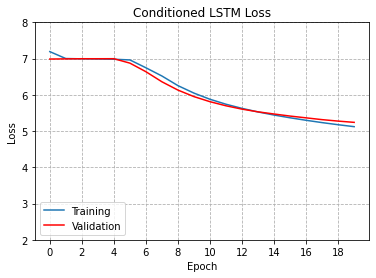

In [201]:
plt.plot(train_loss)
plt.plot(val_loss, 'r')

plt.title('Conditioned LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower left')

plt.yticks(range(2,9,1))
plt.xticks(range(0,20,2))
plt.grid(linestyle='--')

plt.savefig('plots/cond_lstm_loss.png')

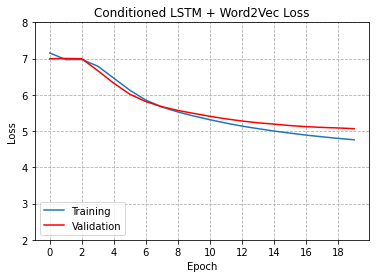

In [202]:
plt.plot(train_loss_w2v)
plt.plot(val_loss_w2v, 'r')

plt.title('Conditioned LSTM + Word2Vec Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower left')

plt.yticks(range(2,9,1))
plt.xticks(range(0,20,2))
plt.grid(linestyle='--')

plt.savefig('plots/cond_lstm_w2v_loss.png')

#### Train loss

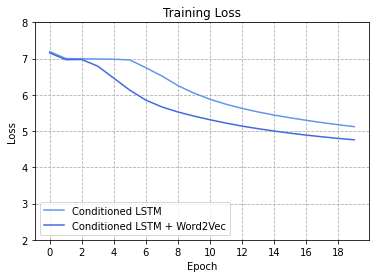

In [220]:
plt.plot(train_loss, 'cornflowerblue')
plt.plot(train_loss_w2v, 'royalblue')

plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Conditioned LSTM', 'Conditioned LSTM + Word2Vec'], loc='lower left')

plt.yticks(range(2,9,1))
plt.xticks(range(0,20,2))
plt.grid(linestyle='--')

plt.savefig('plots/cond_train_loss.png')

#### Validation loss

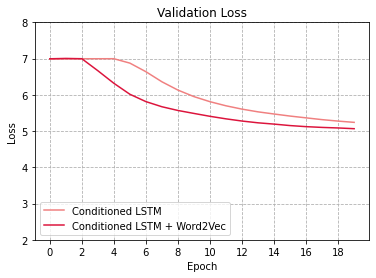

In [203]:
plt.plot(val_loss, 'lightcoral')
plt.plot(val_loss_w2v, 'crimson')

plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Conditioned LSTM', 'Conditioned LSTM + Word2Vec'], loc='lower left')

plt.yticks(range(2,9,1))
plt.xticks(range(0,20,2))
plt.grid(linestyle='--')

plt.savefig('plots/cond_val_loss.png')

#### Perplexity

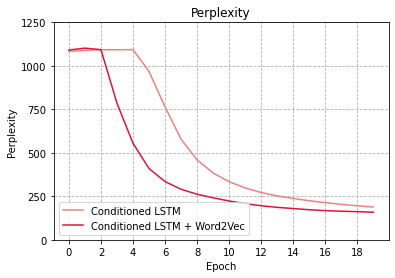

In [219]:
plt.plot(cond_lstm_perp, 'lightcoral')
plt.plot(cond_lstm_w2v_perp, 'crimson')

plt.title('Perplexity')
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.legend(['Conditioned LSTM', 'Conditioned LSTM + Word2Vec'], loc='lower left')

plt.yticks(range(0,1500,250))
plt.xticks(range(0,20,2))
plt.grid(linestyle='--')

plt.savefig('plots/cond_perplexity.png')

## Generation

In [41]:
def word_to_id(word):
    return w2v_model.wv.key_to_index[word]

def id_to_word(id):
    return w2v_model.wv.index_to_key[id]

In [132]:
# predict next token using top k sampling
def predict(model, top_k, t, h=None): # default value as None for first iteration
         
    # tensor inputs
    x = np.array([[word_to_id(t)]])
    inputs = torch.from_numpy(x)

    # detach hidden state from history
    h = tuple([each.data for each in h])

    # get the output of the model
    out, h = model(inputs, h)

    # get the token probabilities
    p = F.softmax(out, dim=1).data
    
    p = p.numpy()
    p = p.reshape(p.shape[1],)

    # get indices of top n values
    top_ids = p.argsort()[-top_k:][::-1]

    # sample id of next word from top n values
    next_id = top_ids[random.sample(range(top_k),1)[0]]

    # return the value of the predicted word and the hidden state
    return id_to_word(next_id), h

In [133]:
gen_batch_size = 1

In [134]:
# PCA for generation batch size
gen_pca_topics = PCA(n_components=n_layers * gen_batch_size, svd_solver='full').fit_transform(trans_topics)
gen_pca_trans = np.transpose(gen_pca_topics)

In [169]:
# function to generate text
def generate(model=cond_lstm, prompt='in this paper', n=10, top_k=10):
    
    model.eval()
    
    h = (torch.FloatTensor(gen_pca_trans.reshape(n_layers, gen_batch_size, n_hidden)),
         torch.zeros(n_layers, gen_batch_size, n_hidden))

    words = prompt.split()

    for t in prompt.split():
        token, h = predict(model, top_k, t, h)
    
    words.append(token)

    # predict subsequent token
    for i in range(n-1):
        token, h = predict(model, top_k, words[-1], h)
        words.append(token)

    return ' '.join(words)

In [53]:
generate(model=cond_lstm_w2v, n=20)

'in this paper presents it is a large number for the corpus and the first annotated corpus our corpus includes to build and'

In [55]:
generate(model=cond_lstm_w2v, n=50, prompt='here we propose a better approach to')

'here we propose a better approach to identify relevant information with high resource text generation we present this approach based on two tasks that do the system used at each time step for training for each task this is a simple solution and provides an overview is available for english in the english chinese hindi chinese text'

In [74]:
generate(model=cond_lstm_w2v, n=100, prompt='even though our approach is giving good results we')

'even though our approach is giving good results we use an attention approach for training the model with a large margin which can also effectively exploit new data in which training and evaluation systems are based on simple models trained at different domains this paper proposes to evaluate several neural neural approaches that require large amounts corpus as well as it will lead the need towards many research purposes to address these limitations for different language generation datasets and is often used in various datasets and the performance that in order of their data will serve this paper will provide valuable research annotation resources in nlp we describe our'

In [83]:
generate(model=cond_lstm_w2v, n=80, prompt='even though our approach is giving satisfactory results it could be improved by')

'even though our approach is giving satisfactory results it could be improved by using both the training time of text specific and a new data based evaluation study that can provide high correlation for out of source data and other language models in order in terms for low language pairs and are used to be made available we describe some challenges on this domain to facilitate the evaluation the paper analysis on a wide number to study and compare them as features for the annotation process the dataset was created at different languages'

In [90]:
generate(model=cond_lstm_w2v, n=50, prompt='in summary the present study demonstrated that')

'in summary the present study demonstrated that by using an attention architecture that enables an efficient training strategy in a supervised model to produce multiple training sets for both different word types and words from different words the proposed system consists the proposed system which uses a model which can capture and learn knowledge for each document'

In [140]:
generate(model=cond_lstm_w2v, n=50, prompt='in this paper we present a novel approach')

'in this paper we present a novel approach that incorporates multi sentence relation based on an input tree and an attention mechanism for automatically linking this problem the model predicts two semantic structures to the source word and propose two types and propose to evaluate different strategies for a language based approach and that our algorithm can generate'

In [166]:
generate(model=cond_lstm_w2v, n=50, prompt='in this paper we present a novel approach', top_k=2)

'in this paper we present a novel approach for the first step of the task of identifying the sentiment and semantic relations of a sentence and a given sentence in the same sentence we present an ensemble method that uses the word level and the word embeddings and the word level and a set and then used the'

## Evaluation

In [191]:
name = {cond_lstm: 'Conditioned LSTM', cond_lstm_w2v: 'Conditioned LSTM + Word2Vec'}
loss = {cond_lstm: val_loss, cond_lstm_w2v: val_loss_w2v}

### Quantitative

In [192]:
# get minimimum validation loss within a set num of epochs
def min_val_loss(model, max_epochs=100):
    return min(loss[model][:max_epochs])

In [193]:
for m in name.keys():
    print("Minimum validation loss for {}: {:.5f}".format(name[m], min_val_loss(m, 50)))
    print("Perplexity for model {}: {:.2f}\n".format(name[m], math.exp(min_val_loss(m, 50))))

Minimum validation loss for Conditioned LSTM: 5.24062
Perplexity for model Conditioned LSTM: 188.79

Minimum validation loss for Conditioned LSTM + Word2Vec: 5.06577
Perplexity for model Conditioned LSTM + Word2Vec: 158.50



### Qualitative

In [224]:
prompts = ['in', 'in this paper', 'in this paper we present', 'in this paper we present a novel approach to']
n_list  = [5, 10, 20, 50]
k_list  = [2, 5, 10, 20]

In [227]:
counter = 0

for m in name.keys():
    for p in prompts:
        for n in n_list:
            for k in k_list:
                counter += 1
                print("=" * 180 + "\n[{}] MODEL: {}  |  PROMPT: '{}'  |  WORDS: {}  |  TOP {}".format(counter, name[m], p, n, k))
                print("=" * 180 + "\n\n {}\n" .format(generate(model=m, prompt=p, n=n, top_k=k)))

[1] MODEL: Conditioned LSTM  |  PROMPT: 'in'  |  WORDS: 5  |  TOP 2

 in this work we propose a

[2] MODEL: Conditioned LSTM  |  PROMPT: 'in'  |  WORDS: 5  |  TOP 5

 in the field of a text

[3] MODEL: Conditioned LSTM  |  PROMPT: 'in'  |  WORDS: 5  |  TOP 10

 in a low dimensional way for

[4] MODEL: Conditioned LSTM  |  PROMPT: 'in'  |  WORDS: 5  |  TOP 20

 in order as our knowledge from

[5] MODEL: Conditioned LSTM  |  PROMPT: 'in'  |  WORDS: 10  |  TOP 2

 in this paper the results show the effectiveness of the approach

[6] MODEL: Conditioned LSTM  |  PROMPT: 'in'  |  WORDS: 10  |  TOP 5

 in order for building automatic and qualitative evaluation in this area

[7] MODEL: Conditioned LSTM  |  PROMPT: 'in'  |  WORDS: 10  |  TOP 10

 in order we investigate several approaches with two neural architectures that

[8] MODEL: Conditioned LSTM  |  PROMPT: 'in'  |  WORDS: 10  |  TOP 20

 in natural languages as this corpus can easily detect how of

[9] MODEL: Conditioned LSTM  |  PROMPT: